In [1]:
#Load
#Load Libraries
import pandas as pd
import numpy as np
import random
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
# Additional Configuration
pd.set_option('display.max_columns', None)
%matplotlib inline

## 1. Data Preprocessing and Scaling

### 1.1 Processing Users.CSV

In [2]:
users = pd.read_csv('users.csv')

In [3]:
users

,Unnamed: 0,idx,steam_id,app_id,game_name,playtime_2weeks,playtime_forever
0,11,11,76561198065791491,359550,Tom Clancy's Rainbow Six Siege,737.0,146677.0
1,12,11,76561198065791491,271590,Grand Theft Auto V,658.0,15255.0
2,13,11,76561198065791491,465280,Yesterday Origins,426.0,426.0
3,14,11,76561198065791491,1097350,Weird West,397.0,397.0
4,15,11,76561198065791491,534380,Dying Light 2,357.0,2644.0
...,...,...,...,...,...,...,...
21921,30876,12643,76561198417886911,513710,SCUM,790.0,5812.0
21922,30877,12643,76561198417886911,250820,SteamVR,754.0,61014.0
21923,30878,12643,76561198417886911,1293830,Forza Horizon 4,100.0,100.0
21924,30879,12643,76561198417886911,1608400,Vermillion,59.0,59.0


In [4]:
# Create a list of columns to remove:
columns = ['Unnamed: 0','steam_id']
users = users.drop(columns,axis = 1)

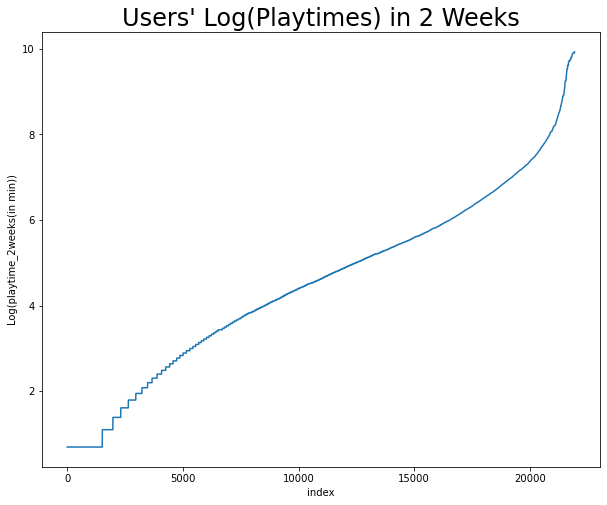

In [5]:
#Visualization and Log Scaling Users Features
users.sort_values('playtime_2weeks', ascending=True, inplace=True)
users['index'] = np.arange(len(users))
users['log_playtime_2weeks'] = np.log(1+users['playtime_2weeks'])
users['log_playtime_forever'] = np.log(1+users['playtime_forever'])
#ax = users.plot.line(x='index', y='playtime_forever')
f,ax=plt.subplots(1,1,figsize = (10,8))
plt.rc('font', size=20) 
plt.plot(users["index"], users["log_playtime_2weeks"])
plt.xlabel('index')
plt.ylabel("Log(playtime_2weeks(in min))")
ax.set_title("Users' Log(Playtimes) in 2 Weeks")
plt.show()

In [6]:
#Sample columns and rows of Users dataframe
print(users.head())

         idx  app_id                        game_name  playtime_2weeks  \
2985    5927  840210  Arkham Horror: Mother's Embrace              1.0   
15361  10320    9900                 Star Trek Online              1.0   
21121  12417  431960                 Wallpaper Engine              1.0   
14060   9820     440                  Team Fortress 2              1.0   
19010  11747  431960                 Wallpaper Engine              1.0   

       playtime_forever  index  log_playtime_2weeks  log_playtime_forever  
2985                1.0      0             0.693147              0.693147  
15361             693.0      1             0.693147              6.542472  
21121            1053.0      2             0.693147              6.960348  
14060          230179.0      3             0.693147             12.346617  
19010             517.0      4             0.693147              6.249975  


### 1.2 Processing Games.CSV

In [7]:
#Log Scaling Games Features
games = pd.read_csv('game_changed.csv')
columns = ['Unnamed: 0']
games= games.drop(columns,axis = 1)
games['log_total_playtime_2weeks'] = np.log(1+games['total_playtime_2weeks'])
games['log_total_playtime_forever'] = np.log(1+games['total_playtime_forever'])

### 1.3 Input Preprocessed Sentiment and Ratings CSV

In [8]:
#Sentiment and Ratings Dataframes
sentiment1 = pd.read_csv("new_sentiment.csv")
sentiment2 = pd.read_csv("sentiment_4800.csv")
sentiment = pd.concat([sentiment1,sentiment2],axis = 0)


### 1.4 Combining all Dataframes to One Dataframe

In [9]:
#Merging Dataframes-Sentiment, Rating, Games and Users
games = games.merge(sentiment,left_on = 'game_name', right_on='game_name',
                            how = 'left')
rating = pd.read_csv("rating.csv")
games = games.merge(rating,left_on = 'game_name', right_on='game_name',
                            how = 'left')
games=games.drop_duplicates(['game_name'])
users_combined = users.merge(games,left_on = 'game_name', right_on='game_name',
                            how = 'left')
users_combined= users_combined.drop(['app_id_y','index'],axis = 1)
users_combined = users_combined.rename(columns={'app_id_x':'app_id'})
users_combined['game_type']= users_combined['game_type'].astype('category')
users_combined['like_degree_2w'] = users_combined['log_playtime_2weeks']/users_combined['log_total_playtime_2weeks']
users_combined['like_degree_f'] = users_combined['log_playtime_forever']/users_combined['log_total_playtime_forever']
users_combined['is_free'] =  users_combined["is_free"].fillna(0)
users_combined['is_free'] = users_combined['is_free'].astype(int)
users_combined['sentiment_R'] = users_combined['subjectivity']*users_combined['polarity']*users_combined['scaled_rating']
print(users_combined.head())

     idx  app_id                        game_name  playtime_2weeks  \
0   5927  840210  Arkham Horror: Mother's Embrace              1.0   
1  10320    9900                 Star Trek Online              1.0   
2  12417  431960                 Wallpaper Engine              1.0   
3   9820     440                  Team Fortress 2              1.0   
4  11747  431960                 Wallpaper Engine              1.0   

   playtime_forever  log_playtime_2weeks  log_playtime_forever game_type  \
0               1.0             0.693147              0.693147       NaN   
1             693.0             0.693147              6.542472       NaN   
2            1053.0             0.693147              6.960348      game   
3          230179.0             0.693147             12.346617      game   
4             517.0             0.693147              6.249975      game   

   price_usd  is_free  recommendations  released_year  total_playtime_2weeks  \
0        NaN        0              NaN    

### 1.5 Further Scaling Some Columns Using MinMaxScaler From Sklearn

In [10]:
#Scale the columns Using MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
users_combined["like_degree_2w"] = scaler.fit_transform(users_combined[["like_degree_2w"]])
users_combined["like_degree_f"] = scaler.fit_transform(users_combined[["like_degree_f"]])
users_combined["released_year"] = scaler.fit_transform(users_combined[["released_year"]])
users_combined["price_usd"] = scaler.fit_transform(users_combined[["price_usd"]])
users_combined['sentiment_R'] = scaler.fit_transform(users_combined[["sentiment_R"]])
print(users_combined.head())

     idx  app_id                        game_name  playtime_2weeks  \
0   5927  840210  Arkham Horror: Mother's Embrace              1.0   
1  10320    9900                 Star Trek Online              1.0   
2  12417  431960                 Wallpaper Engine              1.0   
3   9820     440                  Team Fortress 2              1.0   
4  11747  431960                 Wallpaper Engine              1.0   

   playtime_forever  log_playtime_2weeks  log_playtime_forever game_type  \
0               1.0             0.693147              0.693147       NaN   
1             693.0             0.693147              6.542472       NaN   
2            1053.0             0.693147              6.960348      game   
3          230179.0             0.693147             12.346617      game   
4             517.0             0.693147              6.249975      game   

   price_usd  is_free  recommendations  released_year  total_playtime_2weeks  \
0        NaN        0              NaN    

In [11]:
#Output Processed dataframe as csv
gfg_csv_data = users_combined.to_csv('processed_data.csv', index = True)

### 1.6 Split the dataset of Test/Train on Ratio

In [12]:
#Split Test Train Using 3:7
from sklearn.model_selection import train_test_split
a= users_combined.groupby('idx')
all_test = []
all_train = []
for x,y in a:
    if len(y) > 1:
        train, test = train_test_split(y, train_size = 0.7)
        all_test.append(test)
        all_train.append(train)
    else:
        train = y
        all_train.append(train)
train = pd.concat(all_train, axis = 0)

In [13]:
train

,idx,app_id,game_name,playtime_2weeks,playtime_forever,log_playtime_2weeks,log_playtime_forever,game_type,price_usd,is_free,recommendations,released_year,total_playtime_2weeks,total_playtime_forever,purchased_count,Action,Adventure,Animation&Modeling,Casual,Design & illustration,Documentary,Episodic,Early Access,Gore,Indie,Massively Multiplayer,Movie,Nudity,Photo Editing,Racing,RPG,Sexual Content,Simulation,Sports,Strategy,Utilities,Video Production,Webpublishing,log_total_playtime_2weeks,log_total_playtime_forever,subjectivity,polarity,scaled_rating,like_degree_2w,like_degree_f,sentiment_R
8917,11,524660,RutonyChat,60.0,475.0,4.110874,6.165418,NaN,NaN,0,NaN,NaN,1350,101814,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.208600,11.530913,0.542927,0.589996,0.740891,0.546581,0.534686,0.295909
16712,11,465280,Yesterday Origins,426.0,426.0,6.056784,6.056784,game,0.141414,0,237.0,0.826087,426,426,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.056784,6.056784,0.546324,0.584375,0.830433,1.000000,1.000000,0.330567
16128,11,534380,Dying Light 2,357.0,2644.0,5.880533,7.880426,NaN,NaN,0,NaN,NaN,15537,103177,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.651044,11.544211,0.363389,0.503586,NaN,0.587776,0.682630,NaN
17945,11,271590,Grand Theft Auto V,658.0,15255.0,6.490724,9.632728,NaN,NaN,0,NaN,NaN,151867,14887559,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.930767,16.516037,0.465159,0.506468,0.666041,0.518893,0.583235,0.195645
16487,11,1097350,Weird West,397.0,397.0,5.986452,5.986452,NaN,NaN,0,NaN,NaN,5187,5187,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.554104,8.554104,NaN,NaN,NaN,0.683285,0.699834,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6876,12642,1049590,Eternal Return,32.0,7477.0,3.496508,8.919721,NaN,NaN,0,NaN,NaN,1318,38574,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.184629,10.560360,0.285714,0.521429,NaN,0.458363,0.844642,NaN
20279,12643,457550,Bigscreen Beta,1868.0,2917.0,7.533159,7.978654,NaN,NaN,0,NaN,NaN,2047,3310,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.624619,8.105006,0.543112,0.252709,0.870602,0.987343,0.984411,0.148986
20230,12643,504230,Celeste,1807.0,2299.0,7.499977,7.740664,game,0.191919,0,22582.0,0.913043,9847,79701,11,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9.195024,11.286050,0.581685,0.529533,0.968932,0.805492,0.685861,0.372124
18445,12643,513710,SCUM,790.0,5812.0,6.673298,8.667852,game,0.292929,0,34755.0,0.913043,12244,212900,10,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9.412873,12.268583,NaN,NaN,0.607728,0.692908,0.706508,NaN


In [14]:
test = pd.concat(all_test,axis=0)
test

,idx,app_id,game_name,playtime_2weeks,playtime_forever,log_playtime_2weeks,log_playtime_forever,game_type,price_usd,is_free,recommendations,released_year,total_playtime_2weeks,total_playtime_forever,purchased_count,Action,Adventure,Animation&Modeling,Casual,Design & illustration,Documentary,Episodic,Early Access,Gore,Indie,Massively Multiplayer,Movie,Nudity,Photo Editing,Racing,RPG,Sexual Content,Simulation,Sports,Strategy,Utilities,Video Production,Webpublishing,log_total_playtime_2weeks,log_total_playtime_forever,subjectivity,polarity,scaled_rating,like_degree_2w,like_degree_f,sentiment_R
18249,11,359550,Tom Clancy's Rainbow Six Siege,737.0,146677.0,6.603944,11.895995,game,0.191919,0,622678.0,0.782609,56095,7291880,138,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.934820,15.802272,0.532938,0.167920,0.784613,0.582101,0.752803,0.087548
15346,11,218230,PlanetSide 2,289.0,289.0,5.669881,5.669881,game,NaN,1,645.0,0.652174,7259,557475,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.890135,13.231175,NaN,NaN,0.800894,0.617801,0.428524,NaN
6878,11,594650,Hunt: Showdown,32.0,2774.0,3.496508,7.928406,game,0.393939,0,51636.0,0.956522,49896,1190115,79,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.817716,13.989561,0.516775,0.581034,0.713806,0.285907,0.566737,0.267237
11732,12,397540,Borderlands 3,122.0,122.0,4.812184,4.812184,game,0.595960,0,37172.0,1.000000,23352,145469,52,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10.058481,11.887725,0.463690,0.558333,NaN,0.449664,0.404803,NaN
3675,13,431960,Wallpaper Engine,9.0,63.0,2.302585,4.158883,game,0.030303,0,206425.0,0.913043,60908,5249677,297,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,11.017136,15.473677,0.485938,0.564844,0.966660,0.165389,0.268771,0.330823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,12640,338530,Trouble In The Manor,1.0,1034.0,0.693147,6.942157,game,0.000000,0,134.0,0.782609,1,1034,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,6.942157,0.566667,0.531667,0.534889,1.000000,1.000000,0.200930
6293,12641,271590,Grand Theft Auto V,27.0,4602.0,3.332205,8.434464,NaN,NaN,0,NaN,NaN,151867,14887559,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.930767,16.516037,0.465159,0.506468,0.666041,0.239560,0.510683,0.195645
18305,12643,250820,SteamVR,754.0,61014.0,6.626718,11.018875,game,NaN,1,NaN,NaN,275794,18471787,219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.527413,16.731755,NaN,NaN,NaN,0.503008,0.658561,NaN
8850,12643,1608400,Vermillion,59.0,59.0,4.094345,4.094345,NaN,NaN,0,NaN,NaN,59,59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.094345,4.094345,0.499206,0.567381,NaN,1.000000,1.000000,NaN


# 2. Implementing KNN

### 1.1 Fitting Model

In [15]:
#Create CSR_Matrix
from scipy.sparse import csr_matrix
train=train.drop_duplicates(
['idx','game_name'])
users_combined_pivot = train.pivot(index = 'game_name',
                                           columns = 'idx',
                                           values = {"sentiment_R", "like_degree_2w","like_degree_f","price_usd",
                                                    "is_free","released_year","Action","Adventure",
                                                    "Animation&Modeling","Casual","Design &  illustration", "Documentary","Episodic",
                                                     "Early Access","Gore", "Indie", "Massively Multiplayer", "Movie", "Nudity",
                                                     "Photo Editing", "Racing", "RPG", "Sexual Content", "Simulation", "Sports",
                                                     "Strategy", "Utilities", "Video Production", "Webpublishing"}).fillna(0)
u_matrix = csr_matrix(users_combined_pivot.values)

In [16]:
#Fit Model
from sklearn.neighbors import NearestNeighbors

# Define + Instantiate model:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')

# Fit data using ratings matrix:
knn_model.fit(u_matrix)

# Look at the model properties:
print(knn_model)

NearestNeighbors(algorithm='brute', metric='cosine')


### 1.2 Processing and Showing Results

In [44]:
#Randomly Get a User
test_user = list(test['idx'])
test_user =list(set(test_user))
target_user = np.random.choice(test_user)
print(target_user)
target_gamelist = []
user_game_t = list(zip(train.idx,train.game_name))
for items in user_game_t:
    if items[0] == target_user:
        target_gamelist.append(items[1])
print(target_gamelist) 

10691
['Valheim', 'A Dance of Fire and Ice']


In [45]:
#Get the User's Current PlayList With its Log_Playtime_2Weeks
num_games = users_combined_pivot.shape[0]
temp = list(zip(train.idx,zip(train.game_name,train.log_playtime_2weeks)))
result = []
target_gamelist_i = []
target_log = []
for items in target_gamelist:
    for i in range(num_games):
        if users_combined_pivot.index[i] == items:
            target_gamelist_i.append((i,items))
for items in target_gamelist:
    for i in temp:
        if i[1][0] == items and i[0] == target_user:
          target_log.append((items, i[1][1]))
          
print(target_gamelist_i)
print(target_log)   

[(3567, 'Valheim'), (41, 'A Dance of Fire and Ice')]
[('Valheim', 4.219507705176107), ('A Dance of Fire and Ice', 5.438079308923196)]


### 1.3 Full Recommendation List

In [46]:
#Get the Recommendations for Each Game in User's PlayList
for items in target_gamelist_i:
    distances, indices = knn_model.kneighbors(
    users_combined_pivot.iloc[items[0], : ].values.reshape(1, -1),
    n_neighbors = 6)
    print("\n\n")
    for i in range(len(distances.flatten())):
        if (i == 0):
            print("Recommendations for {}:\n".format(
                users_combined_pivot.index[items[0]]))
  
        else:
            print("{i}: {title}, with distance of {dist}".format(i=i,
                                                                 title=users_combined_pivot.index[indices.flatten()[i]],
                                                                 dist=distances.flatten()[i]))
            result.append((users_combined_pivot.index[items[0]], (users_combined_pivot.index[indices.flatten()[i]],1-distances.flatten()[i])))




Recommendations for Valheim:

1: Metal Unit, with distance of 0.819576633889288
2: Lords Mobile, with distance of 0.8216158467194618
3: Surviving the Aftermath, with distance of 0.8695688717058861
4: Ranch Simulator, with distance of 0.8701465633754438
5: MechWarrior 5: Mercenaries, with distance of 0.8701832291994887



Recommendations for A Dance of Fire and Ice:

1: StarBreak, with distance of 0.6460887007422953
2: NERTS! Online, with distance of 0.6718603846616316
3: Refunct, with distance of 0.7352290868374731
4: Sentinels of the Multiverse, with distance of 0.7859964065938501
5: Realm of the Mad God Exalt, with distance of 0.9034653033971889


In [47]:
#The result list stores the recommendations in the format of (Target_User Played Games, (Recommended Games, Cosine Similarity))
print(result)

[('Valheim', ('Metal Unit', 0.18042336611071197)), ('Valheim', ('Lords Mobile', 0.17838415328053825)), ('Valheim', ('Surviving the Aftermath', 0.13043112829411385)), ('Valheim', ('Ranch Simulator', 0.12985343662455617)), ('Valheim', ('MechWarrior 5: Mercenaries', 0.12981677080051135)), ('A Dance of Fire and Ice', ('StarBreak', 0.3539112992577047)), ('A Dance of Fire and Ice', ('NERTS! Online', 0.32813961533836844)), ('A Dance of Fire and Ice', ('Refunct', 0.2647709131625269)), ('A Dance of Fire and Ice', ('Sentinels of the Multiverse', 0.21400359340614994)), ('A Dance of Fire and Ice', ('Realm of the Mad God Exalt', 0.09653469660281111))]


In [48]:
#The Value = Cosine Similarity * Log_Playtime_2Weeks
rank = []
for i in result:
    for j in target_log:
        if i[0] == j[0]:
            rank.append((i[0],(i[1][0], i[1][1]*j[1])))
print(rank)      

[('Valheim', ('Metal Unit', 0.7612977834979588)), ('Valheim', ('Lords Mobile', 0.7526933092485468)), ('Valheim', ('Surviving the Aftermath', 0.5503551508318267)), ('Valheim', ('Ranch Simulator', 0.5479175763809121)), ('Valheim', ('MechWarrior 5: Mercenaries', 0.5477628646538383)), ('A Dance of Fire and Ice', ('StarBreak', 1.924597713687449)), ('A Dance of Fire and Ice', ('NERTS! Online', 1.7844492526095979)), ('A Dance of Fire and Ice', ('Refunct', 1.4398452244738376)), ('A Dance of Fire and Ice', ('Sentinels of the Multiverse', 1.1637685133371964)), ('A Dance of Fire and Ice', ('Realm of the Mad God Exalt', 0.5249633361889254))]


In [49]:
#The result is Sort by log(1+playtime_2weeks * cosine similarity) in rank
rank.sort(reverse = True, key =lambda x: x[1][1])
print(rank)

[('A Dance of Fire and Ice', ('StarBreak', 1.924597713687449)), ('A Dance of Fire and Ice', ('NERTS! Online', 1.7844492526095979)), ('A Dance of Fire and Ice', ('Refunct', 1.4398452244738376)), ('A Dance of Fire and Ice', ('Sentinels of the Multiverse', 1.1637685133371964)), ('Valheim', ('Metal Unit', 0.7612977834979588)), ('Valheim', ('Lords Mobile', 0.7526933092485468)), ('Valheim', ('Surviving the Aftermath', 0.5503551508318267)), ('Valheim', ('Ranch Simulator', 0.5479175763809121)), ('Valheim', ('MechWarrior 5: Mercenaries', 0.5477628646538383)), ('A Dance of Fire and Ice', ('Realm of the Mad God Exalt', 0.5249633361889254))]


### 1.4 Final Recommendations List Top 5

In [50]:
#Return Top 5 Recommendations 
print(f"Recommendations for User {target_user}:\n")
final_result = []
for i in range(5):
    final_result.append(rank[i][1][0])
    print(f"{rank[i][1][0]} with value {rank[i][1][1]}")
    

Recommendations for User 10691:

StarBreak with value 1.924597713687449
NERTS! Online with value 1.7844492526095979
Refunct with value 1.4398452244738376
Sentinels of the Multiverse with value 1.1637685133371964
Metal Unit with value 0.7612977834979588


### 1.5 Game Based Result

In [76]:
#Random Pick a Game and Display 5 games similar to it
query_index = np.random.choice(users_combined_pivot.shape[0])
print(query_index)

2553


In [77]:
distances, indices = knn_model.kneighbors(
    users_combined_pivot.iloc[query_index, : ].values.reshape(1, -1),
    n_neighbors = 6
)
for i in range(len(distances.flatten())):
  if (i == 0):
    print("Recommendations for {}:\n".format(
        users_combined_pivot.index[query_index]
    ))
  
  else:
    print("{i}: {title}, with distance of {dist}".format(
        i=i,
        title=users_combined_pivot.index[indices.flatten()[i]],
        dist=distances.flatten()[i]
    ))

Recommendations for RAGE 2:

1: Grand Theft Auto V, with distance of 0.9629086990639186
2: Dota 2, with distance of 0.9743082657518738
3: Realm of the Mad God Exalt, with distance of 1.0
4: Realm Grinder, with distance of 1.0
5: Realpolitiks II, with distance of 1.0


## 3. Applying Evaluation Metrics

### 3.1 Method 1: Item-Based Collaborative Filtering

In [25]:
total_games_in_test = list(set(list(test.game_name)))
total_result = []
total_pos = 0

In [28]:
precision = []
recall = []
for user in test_user:
    a=test.groupby('idx')
    games_in_test = list(a.get_group(user).game_name)
    target_gamelist = []
    user_game_t = list(zip(train.idx,train.game_name))
    for items in user_game_t:
        if items[0] == user:
            target_gamelist.append(items[1])
    #Get the User's Current PlayList
    num_games = users_combined_pivot.shape[0]
    temp = list(zip(train.idx,zip(train.game_name,train.log_playtime_2weeks)))
    result = []
    target_gamelist_i = []
    target_log = []
    for items in target_gamelist:
        for i in range(num_games):
            if users_combined_pivot.index[i] == items:
                target_gamelist_i.append((i,items))
    for items in target_gamelist:
        for i in temp:
            if i[1][0] == items and i[0] == user:
                target_log.append((items, i[1][1]))
    #Get the Recommendations for Each Game in User's PlayList
    for items in target_gamelist_i:
        distances, indices = knn_model.kneighbors(
        users_combined_pivot.iloc[items[0], : ].values.reshape(1, -1),
            n_neighbors = 11)
        for i in range(len(distances.flatten())):
            if (i == 0):
                pass
            else:
                result.append((users_combined_pivot.index[items[0]], (users_combined_pivot.index[indices.flatten()[i]],1-distances.flatten()[i])))   
    rank = []
    for i in result:
        for j in target_log:
            if i[0] == j[0]:
                rank.append((i[0],(i[1][0], i[1][1]*j[1])))
    #Sort by log(1+playtime_2weeks * cosine similarity)
    rank.sort(reverse = True, key =lambda x: x[1][1])
    #Return Top 5
    final_result = []
    for i in range(5):
        final_result.append(rank[i][1][0])
    success = 0
    for i in final_result:
        if i in games_in_test:
            success += 1
            total_pos += 1 
    precision.append(success/10)
    recall.append(success/len(games_in_test))
    for i in final_result:
        total_result.append(i)
    

In [29]:
precision_item_based = sum(precision)/len(precision)
recall_item_based = sum(recall)/len(recall)

In [30]:
print(f"The precision is {precision_item_based}, The recall is {recall_item_based}")

The precision is 0.003202049311559393, The recall is 0.020730982114267424


### 3.2 Method 2: Random Recommendation Algorithm

In [31]:
all_games = list(games.game_name)
precision = []
recall = []

In [32]:
for users in test_user:
    a=test.groupby('idx')
    games_in_test = list(a.get_group(user).game_name)
    result = random.sample(all_games, 5)
    success = 0
    for i in result:
        if i in games_in_test:
            success += 1
    precision.append(success/5)
    recall.append(success/len(games_in_test))


In [33]:
precision_random = sum(precision)/len(precision)
recall_random = sum(recall)/len(recall)

In [35]:
print(f"The precision is {precision_random}, The recall is {recall_random}")

The precision is 6.404098623118796e-05, The recall is 0.0003202049311559398


### 3.3 Method 3: Popular Games Algorithm

In [36]:
rank_games = list(zip(games.game_name,train.total_playtime_forever))
precison = []
recall = []

In [37]:
rank_games.sort(reverse = True, key =lambda x: x[1])
for users in test_user:
    a=test.groupby('idx')
    games_in_test = list(a.get_group(user).game_name)
    result = []
    for i in range(5):
        result.append(rank_games[i][0])
    success = 0
    for i in result:
        if i in games_in_test:
            success += 1
    precision.append(success/5)
    recall.append(success/len(games_in_test))


In [38]:
precision_pop = sum(precision)/len(precision)
recall_pop = sum(recall)/len(recall)
print(f"The precision is {precision_pop}, The recall is {recall_pop}")

The precision is 3.202049311559398e-05, The recall is 0.0
